## Packages

In [5]:
import numpy as np
import math
import shapely
import geopandas as gpd
import pandas as pd
import fiona # https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal, pip install shapely, pip install geopandas, https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona, 
import matplotlib.pyplot as plt

## User Defined Functions

In [ ]:
def splits_to_regions_binary(row, splits):
    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

## Data

In [2]:
pa_bg = gpd.read_file('pa_cbg_shapefile')
voting_pop = pd.read_csv("pa_cbg_pop/pop.csv")
voting_pop['GEOID'] = voting_pop['GEO_ID'].apply(lambda x: x.split("US")[1])
pa_bg = pa_bg.merge(voting_pop, on="GEOID")

pa_bg.to_crs("EPSG:2271")
pa_bg['REPRESENTATIVE_POINT'] =  pa_bg.representative_point() # https://gis.stackexchange.com/a/414263
pa_bg['RP_LON'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
pa_bg['RP_LAT'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(pa_bg.shape)
pa_bg.sample(n=5)

(10173, 19)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEO_ID,NAME,Population,REPRESENTATIVE_POINT,RP_LON,RP_LAT
6197,42,049,002200,3,420490022003,Block Group 3,G5030,S,290089,0,+42.0940722,-080.0971046,"POLYGON ((-80.10127 42.09567, -80.09982 42.096...",1500000US420490022003,"Block Group 3, Census Tract 22, Erie County, P...",584,POINT (-80.09711 42.09409),-80.097107,42.094091
789,42,067,070202,1,420670702021,Block Group 1,G5030,S,104284690,1079368,+40.5523936,-077.4711652,"POLYGON ((-77.61228 40.51434, -77.61161 40.514...",1500000US420670702021,"Block Group 1, Census Tract 702.02, Juniata Co...",2018,POINT (-77.47128 40.55206),-77.471281,40.552065
3948,42,003,496101,1,420034961011,Block Group 1,G5030,S,3851248,0,+40.2776226,-079.8365554,"POLYGON ((-79.85593 40.27850, -79.85582 40.278...",1500000US420034961011,"Block Group 1, Census Tract 4961.01, Allegheny...",1195,POINT (-79.83851 40.27655),-79.838506,40.276547
6720,42,017,104201,2,420171042012,Block Group 2,G5030,S,20695883,240107,+40.4161745,-075.0909037,"POLYGON ((-75.13516 40.41465, -75.13282 40.416...",1500000US420171042012,"Block Group 2, Census Tract 1042.01, Bucks Cou...",1049,POINT (-75.09497 40.41925),-75.094973,40.419248
4618,42,039,111300,2,420391113002,Block Group 2,G5030,S,33216054,387,+41.5501464,-080.0771844,"POLYGON ((-80.12708 41.57383, -80.12677 41.573...",1500000US420391113002,"Block Group 2, Census Tract 1113, Crawford Cou...",650,POINT (-80.07779 41.55114),-80.077785,41.551141


## Rewrite

In [36]:
n_districts = 18
n_split = 1
df = pa_bg.copy()

# Get district ratios:
if n_districts % 2 == 0:
    part_a = n_districts/2
    part_b = n_districts/2
else:
    part_a = math.ceil(n_districts/2)
    part_b = math.floor(n_districts/2)

# Get Total Population
pop_total = df['Population'].sum()

# Get Population Center
pop_center_LON = (df['RP_LON'] * df['Population']).sum()/pop_total
pop_center_LAT =  (df['RP_LAT'] * df['Population']).sum()/pop_total

# Re-center LAT/LON relative to the Population Center
df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

# Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


## LOOP for d in 0 to 359 ##
start_angles = np.linspace(0,359,360)
# TODO: Remove once choosing logic is ready
start_angles = [90]
# Pick Starting Angle
angle_ranges = []

for d in start_angles:
    # Reset Angle to be Relative to d
    df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
    df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
    df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

    # Spin Clock Around till you achieve the desired ratio
    i = 0
    captured_pop = 0
    while captured_pop < (part_a)/(part_a+part_b)*pop_total:
        captured_pop += df.loc[i, 'Population']
        i += 1
    final_angle = df.loc[i-1, 'RECENTERED_ANGLE']
    angle_ranges.append((d, final_angle))
# TODO: Define logic for comparing partitions, identify most competitive

# TODO: Choose best partitions (pair of angles)
best_angles = angle_ranges[0]

## Check if angle range loops past 360 for conditions:

a1, a2 = best_angles
if a1 < a2:
    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
elif a1 > a2:
    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)



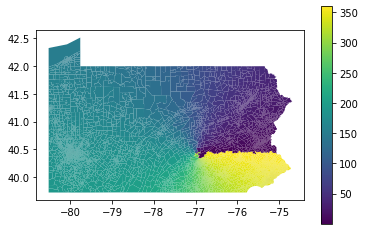

In [63]:
fig, ax = plt.subplots(1, 1)
base = df.plot(column="RECENTERED_ANGLE", ax=ax, legend=True)
plt.show()

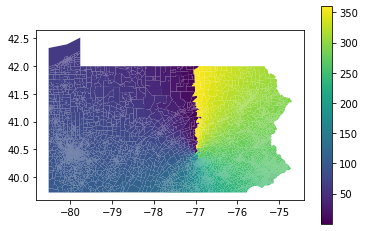

In [64]:
fig, ax = plt.subplots(1, 1)
base = df.plot(column="RESETTED_ANGLE", ax=ax, legend=True)
plt.show()

In [38]:
df[['RECENTERED_LAT', 'RECENTERED_LON', 'RECENTERED_RATIO', 'RECENTERED_ANGLE']].sample(n=5)

,RECENTERED_LAT,RECENTERED_LON,RECENTERED_RATIO,RECENTERED_ANGLE
7375,-0.012098,-2.951888,0.004098,-179.765186
5497,-0.588182,-2.054844,0.286242,-164.026680
8743,-0.284625,2.118357,-0.134361,-7.652493
2025,0.056350,-1.394042,-0.040422,177.685237
10009,-0.380282,1.973344,-0.192710,-10.907729


## Recursive Splitting

In [62]:
holder = []

def split_this(df, n_districts, n_split=1):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df['Population'].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df['Population']).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df['Population']).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        # TODO: Remove once choosing logic is ready
        start_angles = [np.random.choice(start_angles)]
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in start_angles:
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, 'Population']
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']
            angle_ranges.append((d, final_angle))
        # TODO: Define logic for comparing partitions, identify most competitive

        # TODO: Choose best partitions (pair of angles)
        best_angles = angle_ranges[0]

        ## Check if angle range loops past 360 for conditions:

        a1, a2 = best_angles
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1)
        split_this(df_b, part_b, n_split=n_split+1)

        
    else:
        holder.append(df)
        
split_this(pa_bg,18)

In [63]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [70]:
all_districts.groupby("DISTRICT").sum()['Population']

DISTRICT
0.0     573741
2.0     575539
4.0     575155
6.0     576131
8.0     574399
10.0    575456
12.0    574450
14.0    575411
15.0    576177
16.0    574484
18.0    575698
20.0    574627
22.0    575580
24.0    574322
26.0    574814
28.0    575778
30.0    575056
31.0    576730
Name: Population, dtype: int64

In [94]:
# Shuffle for coloring
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

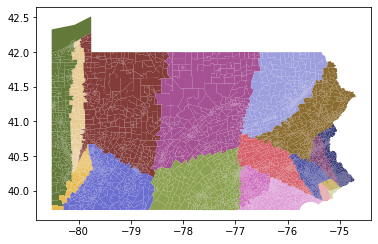

In [95]:
fig, ax = plt.subplots(1, 1)
base = all_districts.plot(column="SHUFFLED", cmap="tab20b", ax=ax, linewidth=0)
plt.show()

<AxesSubplot:>

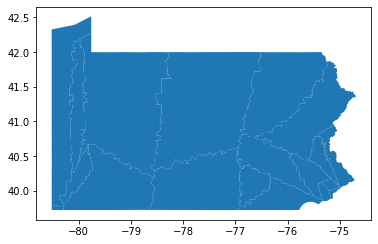

In [87]:
districts_df = all_districts.dissolve(by="DISTRICT")
districts_df.plot(linewidth=4)